In [1]:
from glob import glob
from framed import load_cbmodel
import pandas as pd
from framed.io.sbml import sanitize_id
import cobra
from cobra.io import read_sbml_model
from operator import itemgetter
from multiprocessing import Pool
from tqdm import tqdm
import matplotlib.pyplot as plt
from cobra.flux_analysis import flux_variability_analysis
from matplotlib_venn import venn2

# class for selecting the inhibiting drugs

In [ ]:
class InhibitingDrugsSelection:
    """Dataframe with the drugs from Maier et al 2018 paper
    that have inhibiting information in STITCH
    Receives as input STITCH file ""<taxonomy ID>.actions.v5.0.tsv.gz"
    and Maier et al 2018 supplementary file with drugs and CIDs

    Parameters
    ----------
    STITCHactionsFile: str, default=None
                        "<taxonomy ID>.actions.v5.0.tsv.gz"
    
    ExperimentalPaper: str, default="2018DrugsCIDs.xlsx"
    """
    
    def __init__(self, STITCHactionsFile=None,ExperimentalPaper="2018DrugsCIDs.xlsx"):
        self.STITCHactionsFile=STITCHactionsFile
        self.ExperimentalPaper=ExperimentalPaper
        
    def specificATCclassSelection(self):
        targetSpDF=Drugs.copy()
        ATCdrugs=Drugs.copy()
        ATCdrugs=ATCdrugs[['ATCcodes']]
        classList=['N0']
        indexList=[]
        uniqueSpecies=targetSpDF.targetSpecies.value_counts()
        uniqueSpecies=uniqueSpecies.index.tolist()
        allClassesDF=[]
        for classe in classList:
            classData=[]
            classDrugs=[]
            classIndexes=[]
            classesList=classList.copy()
            classesList.remove(classe)  
            for index, row in ATCdrugs.iterrows():
                rowClasses=[]
                rowDF=ATCdrugs.iloc[[index]]
                rowValues=rowDF.values.tolist()[0]
                rowValues=[item.split() for item in rowValues][0]
                for value in rowValues:
                    if (value.startswith(classe) or value.startswith("Q"+classe)):
                        classIndexes.append(index)     
            classIndexes=list(set(classIndexes))                
            if classIndexes != []:
                targetSpec=targetSpDF[targetSpDF.index.isin(classIndexes)]
        targetSpec    


### loading excel with effect of drugs on proteins

In [2]:
InhibitProteinsDF=pd.read_excel("Btheta_2018NeuroInhibit.xlsx")
print('species', list(InhibitProteinsDF.targetSpecies.unique()))
InhibitProteinsDF.head()

species ['human', 'protozoa', 'metazoan parasites']


,Unnamed: 0,STITCHid,CarveMeID,ProteinName,symbol,prestwickID,DrugName,ATCcodes,targetSpecies,CIDno,item_id_a,score
0,213,226186.BT_1971,WP_011108073_1,catalase,NaN,Prestw-249,Bupropion hydrochloride,N06AX12,human,444,CIDm00000444,604
1,338,226186.BT_3642,WP_008762587_1,sodium-dependent transporter,NaN,Prestw-17,Levodopa,N04BA01,human,836,CIDm00000836,450
2,214,226186.BT_1971,WP_011108073_1,catalase,NaN,Prestw-458,Melatonin,N05CH01,human,896,CIDs00000896,604
3,110,226186.BT_0673,WP_008761351_1,NAD(P)H-dependent oxidoreductase,NaN,Prestw-458,Melatonin,N05CH01,human,896,CIDm00000896,644
4,292,226186.BT_3186,WP_011108698_1,dihydrolipoyl dehydrogenase,lpdA,Prestw-868,Acetaminophen,N02BE01,human,1983,CIDm00001983,461


## Neuroactive drugs that have STITCH info. and p-value<=0.01(i.e., had effect on bacterium's growth)

In [3]:
s3Info=pd.read_excel('S3_reduced.xlsx')
# s3Info

In [4]:
NeuroPrest=list(InhibitProteinsDF.prestwickID.unique())
Neuros3Info=s3Info.copy()
Neuros3Info=s3Info[s3Info['prestwick_ID'].isin(NeuroPrest)]
# Neuros3Info

In [5]:
lastCol=Neuros3Info.columns[-1]
signifNeuroPaper = Neuros3Info[Neuros3Info[lastCol] <= 0.01]
# signifNeuroPaper
print('number of drugs that had effect on growth in vitro:', len(signifNeuroPaper))

number of drugs that had effect on growth in vitro: 0


## Knock-out effect of each drug

In [6]:
DrugsNamesDF=InhibitProteinsDF.copy()
DrugsNamesDF=DrugsNamesDF[['DrugName','prestwickID']]
DrugsNamesDF.drop_duplicates(inplace=True)

# print(DrugsNamesDF)

UniqueDrugsIdsList=DrugsNamesDF['prestwickID'].unique().tolist()

# UniqueDrugsIdsList
# print(UniqueDrugsIdsList)

ProteinsNamesDF=InhibitProteinsDF.copy()
ProteinsNamesDF=ProteinsNamesDF[['CarveMeID', 'ProteinName', 'symbol']]
ProteinsNamesDF.drop_duplicates(inplace=True)
# print(ProteinsNamesDF)

### proteins in stitch vs model

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


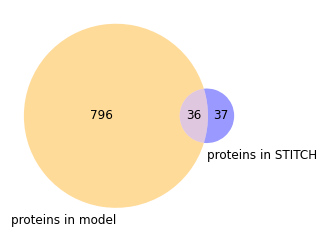

In [7]:
proteinsSTITCH=list(InhibitProteinsDF.CarveMeID.unique())
Model=read_sbml_model("LBmedium_Btheta_gram_gapFilled_after.xml.gz")
proteinsModel=[]
for x in Model.genes:
    proteinsModel.append(x.id)
Venn=venn2([set(proteinsModel), set(proteinsSTITCH)],set_labels=('proteins in model', 'proteins in STITCH'), set_colors=('orange', 'blue'))
for text in Venn.subset_labels:
    text.set_fontsize(12)

# <span style='color:red'> **CarveMe** </span> model

## for each drug, knock-out <span style='color:red'> **ALL proteins AT THE SAME TIME** </span>

## see how knock-out affects <span style='color:brown'> **GROWTH** </span> 
## <span style='color:brown'> **LB[-O2]** </span>

In [ ]:
class DrugEffectGrowth:
    """Dataframe with information on the effect of drugs on bacterium's growth
       Gives info. about no. of proteins and reactions affected
       Carveme and curated models of SAME strain

    Parameters
    ----------
    StrainName: str, default=None
        Must be the initial of the genus,
        followed by the specific term of the species
        (e.g. Bacteroides thetaiotaomicron -> Bthetaiotaomicron)

    Template: list, {"universal", "gram"}, default=None
    GapProcess: list, {"gapAfter", "gapDuring", "NoGap"}, default=None
    Medium: list, {"M9", "LB", "NoMedium"}, default=None

    CuratedModel: str, {"curated"}, default=None
        If a curated model exists, the file must have 
        "curated" in the name
    """
    
    def __init__(self, StrainName=None,Template=None, GapProcess=None, Medium=None, *, CuratedModel=None):
        self.StrainName=StrainName
        self.Template=Template
        self.GapProcess=GapProcess
        self.Medium=Medium
        self.CuratedModel=CuratedModel
    
    def getFilesNamesList(self):
        '''Returns a list of filenames from models
        with **same Template and same GapProcess**
        and from curated models
        
        fileName example: "Bthetaiotaomicron_gram_gapAfter_M9.xml.gz"
        '''
    
        filesNamesList=[]
        Files = '*.xml.gz'
        carvemeVars=[self.StrainName, self.Template, self.GapProcess, self.Medium]
        if all(carvemeVar is not None for carvemeVar in carvemeVars): #if none of these is None
            for fileName in glob(Files):
                if "Ensemble" not in fileName:
                    if self.StrainName in fileName:
                        for template in self.Template:
                            if template in fileName:
                                for gapP in self.GapProcess:
                                    if gapP in fileName:
                                        for medium in self.Medium:
                                            if medium in fileName:
                                                filesNamesList.append(fileName)
        CuratedFiles = '*.xml'
        curatedVars=[self.StrainName, self.CuratedModel]
        if all(curatedVar is not None for curatedVar in curatedVars):
            for curatedFileName in glob(CuratedFiles):
                if self.StrainName in curatedFileName:
                    if self.CuratedModel in curatedFileName:
                        filesNamesList.append(curatedFileName)
        return filesNamesList
    
    def drugEffect(self):
        '''Makes dataframe with basic analysis of effect of drugs of models
           except of curated models with LB and M9 media
        '''
        
        filesList=self.getFilesNamesList()
        if filesList: #if filesList is not empty, i.e., has at least one file name
            modelsDF = pd.DataFrame(columns=['analysis']) 
            modelsDataframes=[]
            for fileName in filesList:
                model=read_sbml_model(fileName)  
                


LB_data=[]
for drugId in tqdm(UniqueDrugsIdsList): #for each drug
    drugName=DrugsNamesDF.loc[DrugsNamesDF['prestwickID'] == drugId, 'DrugName']
    print('drug ID:', drugId, 'drug name:',drugName.item())
    Model=read_sbml_model("LBmedium_Btheta_gram_gapFilled_after.xml.gz")
    ObjValue_before=Model.optimize().objective_value
    fluxBefore=flux_variability_analysis(Model)
    fluxBefore=fluxBefore.round(0)
    genesIdsList=[]
    for x in Model.genes:
        genesIdsList.append(x.id)
    SpecificDrugDF = InhibitProteinsDF[InhibitProteinsDF['prestwickID'] == drugId] #for each drug, get the corresponding rows
    UniqueProteinIds = SpecificDrugDF['CarveMeID'].unique().tolist()
    IP_Stitch=len(UniqueProteinIds)
    ProteinINmodel=[]
    for proteinId in UniqueProteinIds:
        if proteinId in genesIdsList:
            ProteinINmodel.append(proteinId)
    IP_Model=len(ProteinINmodel)
    if ProteinINmodel: #if list is not empty
        cobra.manipulation.knock_out_model_genes(Model, ProteinINmodel)
        ObjValue_after=Model.optimize().objective_value
        fluxAfter=flux_variability_analysis(Model)
        fluxAfter=fluxAfter.round(0)
        fluxesCompare=fluxBefore.compare(fluxAfter) 
        TotalAffectedRxs=len(fluxesCompare)       
        percentFBAchange=abs(((ObjValue_after-ObjValue_before)/ObjValue_before)*100)
        DataRow=[drugId, drugName.item(), IP_Stitch, IP_Model,TotalAffectedRxs, percentFBAchange]
        LB_data.append(DataRow)
    else:
        DataRow=[drugId, drugName.item(), IP_Stitch, IP_Model, IP_Model, 0]
        LB_data.append(DataRow)
            
LB_df=pd.DataFrame(LB_data, columns=['drugId', 'drugName', 'StitchInhibtProteins', 'modelInhibtProteins','AffectedRxs', 'Growth%Change'])
LB_df=LB_df.set_index('drugId')
# LB_df


                modelName=fileName.replace(".gz", '')
                modelName=modelName.replace(".xml", '')
                modelDF=pd.DataFrame(ModelData, columns=['analysis',  modelName]) 
                modelsDataframes.append(modelDF)
            for each_DF in modelsDataframes:
                modelsDF=pd.merge(each_DF, modelsDF, on='analysis', how='outer').fillna(False)
            modelsDF=modelsDF.round(1)
            
        else: #if there is no file name
#             modelsDF=pd.DataFrame() #make empty dataframe
            modelsDF=None
            
        return modelsDF

## <span style='color:brown'> **ALL exchange** </span> fluxes as active

In [ ]:
ALL_data=[]
for drugId in tqdm(UniqueDrugsIdsList):
    print('drug ID:', drugId)
    Model=read_sbml_model("gram_NoMedium_NoGap.xml.gz")
    
#     print('non-zero/active exchange reactions of model \n', Model.medium)
#     allExchangeRxs = [v for v in dir(Model.exchanges) if v.startswith("EX_")]
#     for ExRx in allExchangeRxs:
#         if ExRx not in Model.medium.keys():
#             Model.reactions.get_by_id(ExRx).bounds = (-1000, 1000)
# #     print('non-zero/active exchange reactions of model \n', Model.medium)

    genesIdsList=[]
    for x in Model.genes:
        genesIdsList.append(x.id)
    SpecificDrugDF = InhibitProteinsDF[InhibitProteinsDF['prestwickID'] == drugId]
    UniqueProteinIds = SpecificDrugDF['CarveMeID'].unique().tolist()
    IPStitch=len(UniqueProteinIds)
#     print('number of inhibited proteins in STITCH files:', len(UniqueProteinIds))
#     print(UniqueProteinIds)
    ProteinINmodel=[]
    for proteinId in UniqueProteinIds:
        if proteinId in genesIdsList:
            ProteinINmodel.append(proteinId)
#             ProteinINmodel.append("WP_004291965_1") # to test if it's working by using an essential protein
    AllIPModel=len(ProteinINmodel)
#     print('number of inhibited proteins in Btheta model:', len(ProteinINmodel))
#     print('inhibited proteins', ProteinINmodel)
    ObjValue_before=Model.optimize().objective_value
    if ProteinINmodel: #if list is not empty
        cobra.manipulation.knock_out_model_genes(Model, ProteinINmodel)
#         print(len(cobra.manipulation.knock_out_model_genes(Model, ProteinINmodel)),'Reactions that had the bounds turned to zero: \n', cobra.manipulation.knock_out_model_genes(Model, ProteinINmodel))
        ObjValue_after=Model.optimize().objective_value
    
        AllDataRow=[drugId,ObjValue_before, ObjValue_after]
        ALL_data.append(AllDataRow)
        
        if ObjValue_after != ObjValue_before:
            print('objective value before knock-out:', ObjValue_before)
            print('objective value after knock-out:', ObjValue_after)
            
    else:
        DataRow=[drugId, ObjValue_before, ObjValue_before]
        ALL_data.append(DataRow)
            
All_df=pd.DataFrame(ALL_data, columns=['drugId', 'All_FBA_before', 'All_FBA_after'])
All_df=All_df.set_index('drugId')
# All_df=All_df.round(2)
# All_df

In [11]:
allcarveme=All_df.copy()
allcarveme['AllGrowth%Change']=abs(((allcarveme['All_FBA_after']-allcarveme['All_FBA_before'])/allcarveme['All_FBA_before'])*100)
# allcarveme['AllGrowth%Change']=abs(((allcarveme['All_FBA_after']-allcarveme['All_FBA_before'])))

## do the same for <span style='color:brown'> **M9[-O2]** </span>

In [ ]:
M9Data=[]
for drugId in tqdm(UniqueDrugsIdsList):
    print('drug ID:', drugId)
    Model=read_sbml_model("Btheta_gram_gapFilled_after.xml.gz")
    genesIdsList=[]
    for x in Model.genes:
        genesIdsList.append(x.id)
    SpecificDrugDF = InhibitProteinsDF[InhibitProteinsDF['prestwickID'] == drugId]
    UniqueProteinIds = SpecificDrugDF['CarveMeID'].unique().tolist()
    IPStitch=len(UniqueProteinIds)
#     print('number of inhibited proteins in STITCH files:', len(UniqueProteinIds))
#     print(UniqueProteinIds)
    ProteinINmodel=[]
    for proteinId in UniqueProteinIds:
        if proteinId in genesIdsList:
            ProteinINmodel.append(proteinId)
#             ProteinINmodel.append("WP_004291965_1") # to test if it's working by using an essential protein
#     print('number of inhibited proteins in Btheta model:', len(ProteinINmodel))
    M9IPModel=len(ProteinINmodel)
#     print('inhibited proteins', ProteinINmodel)
    ObjValue_before=Model.optimize().objective_value
#     print('objective value before knock-out:', ObjValue_before)
    if ProteinINmodel: #if list is not empty
        cobra.manipulation.knock_out_model_genes(Model, ProteinINmodel)
#         print(len(cobra.manipulation.knock_out_model_genes(Model, ProteinINmodel)),'Reactions that had the bounds turned to zero: \n', cobra.manipulation.knock_out_model_genes(Model, ProteinINmodel))
        ObjValue_after=Model.optimize().objective_value
    
        M9DataRow=[drugId, ObjValue_before, ObjValue_after]
        M9Data.append(M9DataRow)
    
        if ObjValue_after != ObjValue_before: #if objective value changes, print its value
            print('objective value before knock-out:', ObjValue_before)
            print('objective value after knock-out:', ObjValue_after)
            
    else:
        DataRow=[drugId, ObjValue_before, ObjValue_before]
        M9Data.append(DataRow)
            
M9_df=pd.DataFrame(M9Data, columns=['drugId','M9_FBA_before', 'M9_FBA_after'])
M9_df=M9_df.set_index('drugId')
# M9_df=M9_df.round(2)
# M9_df

In [13]:
m9carveme=M9_df.copy()
m9carveme['m9Growth%Change']=abs(((m9carveme['M9_FBA_after']-m9carveme['M9_FBA_before'])/m9carveme['M9_FBA_before'])*100)
# m9carveme['m9Growth%Change']=abs(((m9carveme['M9_FBA_after']-m9carveme['M9_FBA_before'])))

In [14]:
concatDF=pd.concat([LBcarveme,allcarveme, m9carveme], axis=1)
concatDF
# concatDF.to_excel('FBA_2018neuroactive.xlsx')

,drugName,StitchInhibtProteins,modelInhibtProteins,LB_FBA_before,LB_FBA_after,LBGrowth%Change,All_FBA_before,All_FBA_after,AllGrowth%Change,M9_FBA_before,M9_FBA_after,m9Growth%Change
drugId,,,,,,,,,,,,
Prestw-249,Bupropion hydrochloride,1,1,1.403247,1.403247e+00,0.000000,55.007241,55.007241,0.000000e+00,0.854575,8.545683e-01,0.00083
Prestw-17,Levodopa,1,0,1.403247,1.403247e+00,0.000000,55.007241,55.007241,0.000000e+00,0.854575,8.545754e-01,0.00000
Prestw-458,Melatonin,2,2,1.403247,1.403247e+00,0.000000,55.007241,55.007241,0.000000e+00,0.854575,8.545683e-01,0.00083
Prestw-868,Acetaminophen,14,10,1.403247,7.532996e-17,100.000000,55.007241,54.873010,2.440250e-01,0.854575,2.110463e-14,100.00000
Prestw-74,Amitryptiline hydrochloride,1,0,1.403247,1.403247e+00,0.000000,55.007241,55.007241,0.000000e+00,0.854575,8.545754e-01,0.00000
Prestw-1207,Acetylsalicylic acid,14,8,1.403247,1.403247e+00,0.000000,55.007241,55.007241,1.291726e-14,0.854575,8.545683e-01,0.00083
Prestw-305,Bupivacaine hydrochloride,1,1,1.403247,1.403247e+00,0.000000,55.007241,55.007241,0.000000e+00,0.854575,8.545754e-01,0.00000
Prestw-1256,Caffeine,1,1,1.403247,1.400168e+00,0.219463,55.007241,54.223737,1.424365e+00,0.854575,8.545754e-01,0.00000
Prestw-52,Carbamazepine,16,5,1.403247,1.403247e+00,0.000000,55.007241,55.007241,0.000000e+00,0.854575,8.545754e-01,0.00000


In [ ]:
LBpercentDF=concatDF.copy().round(2)
LBpercentDF=LBpercentDF[["LBGrowth%Change"]]
LBpercentDF=pd.DataFrame(LBpercentDF['LBGrowth%Change'].value_counts())
LBpercentDF.index.names = ['change']
LBpercentDF=LBpercentDF.reset_index()
percentVal=LBpercentDF["change"].tolist()
count=LBpercentDF["LBGrowth%Change"].tolist()
# plt.figure(figsize = (6,4))
fig, ax =  plt.subplots(figsize = (6,4))
ax.bar(percentVal, count, width = 5)
plt.xticks(fontsize=12)
plt.xlim(0,100)
plt.title('Effect of Neuroactive drugs on growth rate \n LB medium',fontsize=12, fontweight='bold')
plt.xlabel('Percentage change',fontsize=12)
plt.ylabel('Number of drugs',fontsize=12)

for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='left', va='top',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')
    
plt.savefig('neuroDrugs_carveme_graphs_lb.png', bbox_inches="tight")

In [ ]:
allpercentDF=concatDF.copy().round(2)
allpercentDF=allpercentDF[["AllGrowth%Change"]]
allpercentDF=pd.DataFrame(allpercentDF['AllGrowth%Change'].value_counts())
allpercentDF.index.names = ['change']
allpercentDF=allpercentDF.reset_index()
percentVal=allpercentDF["change"].tolist()
count=allpercentDF["AllGrowth%Change"].tolist()
fig, ax =  plt.subplots(figsize = (6,4))
ax.bar(percentVal, count, width = 5, color="gray")
plt.xticks(fontsize=12)
plt.xlim(0,100)
plt.title('Effect of Neuroactive drugs on growth rate \n Complete medium',fontsize=12, fontweight='bold')
plt.xlabel('Percentage change',fontsize=12)
plt.ylabel('Number of drugs',fontsize=12)


for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='left', va='top',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')
plt.savefig('neuroDrugs_carveme_graphs_all.png', bbox_inches="tight")

In [ ]:
m9percentDF=concatDF.copy().round(2)
m9percentDF=m9percentDF[["m9Growth%Change"]]
m9percentDF=pd.DataFrame(m9percentDF['m9Growth%Change'].value_counts())
m9percentDF.index.names = ['change']
m9percentDF=m9percentDF.reset_index()
percentVal=sorted(m9percentDF["change"].tolist())
count=m9percentDF["m9Growth%Change"].tolist()
fig, ax =  plt.subplots(figsize = (6,4))
ax.bar(percentVal, count, width = 5, color='green')
plt.xticks(fontsize=12)
plt.xlim(0,100)
plt.title('Effect of Neuroactive drugs on growth rate \n M9 medium',fontsize=12, fontweight='bold')
plt.xlabel('Percentage change',fontsize=12)
plt.ylabel('Number of drugs',fontsize=12)

for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='left', va='top',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')
plt.savefig('neuroDrugs_carveme_graphs_m9.png', bbox_inches="tight")

In [257]:
EffectDrugs=concatDF.copy().round(2)
# EffectDrugs=EffectDrugs.reset_index()
EffectDrugs=EffectDrugs[['LBGrowth%Change', 'AllGrowth%Change', 'm9Growth%Change']]
indexList=[]
for index, row in EffectDrugs.iterrows():
    rowDF=EffectDrugs.loc[index]
    rowValues=row.values.tolist()
    res = any(val == 100.00 for val in rowValues)
    if res: #if p<0.05 for at least one cancer subtype 
        indexList.append(index)
print('number of drugs with effect on growth', len(indexList))

number of drugs with effect on growth 3


In [258]:
effectiveDrugs=concatDF.copy()
effectiveDrugs=effectiveDrugs[effectiveDrugs.index.isin(indexList)]
effectiveDrugs

,drugName,StitchInhibtProteins,modelInhibtProteins,LB_FBA_before,LB_FBA_after,LBGrowth%Change,All_FBA_before,All_FBA_after,AllGrowth%Change,M9_FBA_before,M9_FBA_after,m9Growth%Change
drugId,,,,,,,,,,,,
Prestw-868,Acetaminophen,14,10,1.403247,7.532996e-17,100.0,55.007241,54.873010,0.244025,0.854575,2.110463e-14,100.0
Prestw-861,Gabapentin,11,9,1.403247,3.110940e-16,100.0,55.007241,54.955192,0.094623,0.854575,4.290240e-15,100.0
Prestw-501,Vigabatrin,8,8,1.403247,3.110940e-16,100.0,55.007241,54.955192,0.094623,0.854575,4.290240e-15,100.0


## essential genes affected

In [ ]:
LBmodel=read_sbml_model('Bthetaiotaomicron_gram_gapAfter_LB.xml.gz')
LBmodel.optimize()
essentGenes=cobra.flux_analysis.find_essential_genes(LBmodel, threshold=None, processes=None)
essentGenesList=[]
for gene in essentGenes:
    essentGenesList.append(gene.id)
if "spontaneous" in essentGenesList:
    essentGenesList.remove("spontaneous")
essentGenesList=set(essentGenesList) #all essential genes in LB carveme model
neuroGenes=set(list(InhibitProteinsDF.CarveMeID.unique())) #genes with interactions with neuro drugs
essentNeuroGenes=list(essentGenesList.intersection(neuroGenes))
essentRows=InhibitProteinsDF[InhibitProteinsDF.CarveMeID.isin(essentNeuroGenes)] #drugs that interact with essential genes
essentRows

In [ ]:
m9model=read_sbml_model("Btheta_gram_gapFilled_after.xml.gz")
m9model.optimize()
essentGenes=cobra.flux_analysis.find_essential_genes(m9model, threshold=None, processes=None)
essentGenesList=[]
for gene in essentGenes:
    essentGenesList.append(gene.id)
if "spontaneous" in essentGenesList:
    essentGenesList.remove("spontaneous")
essentGenesList=set(essentGenesList) #all essential genes in LB carveme model
neuroGenes=set(list(InhibitProteinsDF.CarveMeID.unique())) #genes with interactions with neuro drugs
essentNeuroGenes=list(essentGenesList.intersection(neuroGenes))
essentRows=InhibitProteinsDF[InhibitProteinsDF.CarveMeID.isin(essentNeuroGenes)] #drugs that interact with essential genes
essentRows

In [290]:
list(essentRows.ProteinName)

['acyl-CoA dehydrogenase family protein',
 'aminotransferase class I/II-fold pyridoxal phosphate-dependent enzyme',
 'aminotransferase class I/II-fold pyridoxal phosphate-dependent enzyme']